<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/04S_CNN_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'*' - блок предоставлен для ознакомления. Он не является частью, которую надо выполнять

# Классификация здоровых и зараженных малярией клеток

Загрузим данные с фотографиями зараженных и незараженных малярией клеток

In [1]:
!wget https://kodomo.fbb.msu.ru/FBB/ml/malaria_dataset.zip

--2024-05-10 10:44:37--  https://kodomo.fbb.msu.ru/FBB/ml/malaria_dataset.zip
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353903672 (338M) [application/zip]
Saving to: ‘malaria_dataset.zip’

malaria_dataset.zip 100%[===================>] 337.51M  15.5MB/s    in 22s     

2024-05-10 10:45:02 (15.1 MB/s) - ‘malaria_dataset.zip’ saved [353903672/353903672]



In [2]:
!unzip malaria_dataset.zip > /dev/null

Посмотрим на несколько наших картинок

In [3]:
from IPython.display import Image

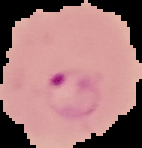

In [4]:
Image(filename="cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png")

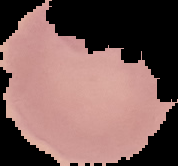

In [5]:
Image(filename="cell_images/Uninfected/C99P60ThinF_IMG_20150918_140900_cell_66.png")

Немного видоизменим наши картинки при помощи набора преобразований. Для этого импортируем эти преобразования из pytorchvision

In [6]:
import torch
from torchvision.transforms import Compose,  ToTensor, Resize

transform=Compose([Resize((32,32)),
                  ToTensor()])

Загрузим наш датасет

In [11]:
from torchvision import datasets
data = datasets.ImageFolder(root="cell_images",
                            transform=transform)

Посмотрим на размер наших данных

In [12]:
df_size=len(data)
print('Size = {}'.format(df_size))

Size = 27558


Разобьем наши данные на обучение и тест. Какой-то явной дополнительной структуры в датасете не прослеживается, потому просто разобьем на обучение и валидацию

In [14]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms

In [15]:
TEST_SIZE = int(0.25 * df_size)
VAL_SIZE = int(0.25 * (df_size - TEST_SIZE))

all_train_dataset, test_dataset = torch.utils.data.random_split(data,
                                                            [df_size - TEST_SIZE, TEST_SIZE],
                                                            generator=torch.Generator().manual_seed(42))

train_dataset, val_dataset = torch.utils.data.random_split(all_train_dataset,
                                                            [df_size - TEST_SIZE - VAL_SIZE, VAL_SIZE],
                                                            generator=torch.Generator().manual_seed(42))

In [16]:
import torch

# по аналогии с part_1 оформить dataloader'ы
train_loader=torch.utils.data.DataLoader(train_dataset,
                                         batch_size=128,
                                         shuffle=True)

val_loader=torch.utils.data.DataLoader(val_dataset,
                                         batch_size=2*128,
                                         shuffle=False)

test_loader=torch.utils.data.DataLoader(test_dataset,
                                         batch_size=2*128,
                                         shuffle=False)

In [17]:
for X, y in train_loader:
  break

In [18]:
X.shape, y.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [19]:
y

tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1])

In [23]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.featurizer = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2),
                                        # Conv2d 3x3, in_c = 8, out channels = 32,
                                        nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
                                        nn.ReLU(),
                                        # MaxPool 2x2
                                        nn.MaxPool2d(2)
                                        )
        self.fc = nn.Sequential(nn.Flatten(),
                                # linear layer 32 * 6 * 6 -> 64
                                nn.Linear(32 * 6 * 6, 64),
                                nn.ReLU(),
                                nn.Linear(64, 1))

    def forward(self, x):
        x = self.featurizer(x)
        x = self.fc(x)
        return x

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
model = ConvNet().to(device)
print(model)

ConvNet(
  (featurizer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [26]:
import torch.optim as optim
import torch.nn.functional as F

criteria=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters())


Обучим модель

In [27]:
NUM_EPOCHS=10

In [29]:
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    print("%{}".format(epoch*100/NUM_EPOCHS))
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float()
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criteria(outputs, labels)
        train_loss += loss.detach() * labels.shape[0]
        # we must backpropagate gradient YOUR CODE HERE
        loss.backward()
        optimizer.step()
    print(train_loss / len(train_dataset))


    val_loss = 0
    model.eval()
    for inputs, labels in val_loader:
      with torch.no_grad():
          inputs = inputs.to(device)
          labels = labels.unsqueeze(1).float()
          labels = labels.to(device)

          outputs = model(inputs)
          loss = criteria(outputs, labels)
          val_loss += loss.detach() * labels.shape[0]

    print(val_loss / len(val_dataset))

print('Finished Training')

%0.0
tensor(0.6440)
tensor(0.6188)
%10.0
tensor(0.5960)
tensor(0.6013)
%20.0
tensor(0.5614)
tensor(0.5630)
%30.0
tensor(0.5246)
tensor(0.4944)
%40.0
tensor(0.4832)
tensor(0.4662)
%50.0
tensor(0.4376)
tensor(0.4058)
%60.0
tensor(0.3847)
tensor(0.3656)
%70.0
tensor(0.3460)
tensor(0.3402)
%80.0
tensor(0.3099)
tensor(0.3141)
%90.0
tensor(0.2788)
tensor(0.2687)
Finished Training


In [30]:
print("\nTesting...")

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)

        y_true.append(labels.numpy())

        outputs = model(inputs)

        probs = torch.sigmoid(outputs)
        predicted = probs > 0.5
        y_pred.append(predicted.squeeze(1).cpu().numpy())

print("\nFinished Training")


Testing...

Finished Training


In [31]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [32]:
np.mean(y_true == y_pred)

0.8943293981033482

## Правильное разбиение

А теперь внимательно прочитаем [описание](https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html) датасета и обнаружим, что вообще-то говоря, разные клетки взяты от разных пациентов. Более того, у больных пациентов были и здоровые клетки, которые тоже были добавлены в датасет

In [ ]:
!wget  https://data.lhncbc.nlm.nih.gov/public/Malaria/patientid_cellmapping_parasitized.csv
!wget  https://data.lhncbc.nlm.nih.gov/public/Malaria/patientid_cellmapping_uninfected.csv

In [ ]:
infected_images = {}

with open("patientid_cellmapping_parasitized.csv") as inp:
    for line in inp:
        name, images = line.strip().split(",", 1)
        name = name.strip()
        images = images.replace("[", "").replace("]", "").split(",")
        images = [x.strip().replace("'", "") for x in images]
        images = [x for x in images if x]

        infected_images[name] = images

In [ ]:
uninfected_images = {}
with open("patientid_cellmapping_uninfected.csv") as inp:
    for line in inp:
        name, images = line.strip().split(",", 1)
        name = name.strip()
        images = images.replace("[", "").replace("]", "").split(",")
        images = [x.strip().replace("'", "") for x in images]
        images = [x for x in images if x]

        uninfected_images[name] = images

In [ ]:
infected = list(infected_images.keys())

Поделим больных так, чтобы в трейн попало порядка 80% фотографий больных клеток

In [ ]:
infected_train = []
count_train = 0
infected_val = []
count_val = 0

for inf in infected:
    if  count_val * 4 > count_train :
        infected_train.append(inf)
        count_train += len(infected_images[inf])
    else:
        infected_val.append(inf)
        count_val += len(infected_images[inf])

In [ ]:
count_val, count_train

In [ ]:
count_val / (count_train + count_val)

In [ ]:
len(infected_train), len(infected_val)

Поделим аналогично здоровых

In [ ]:
uninfected = list(set(uninfected_images.keys()) - set(infected))

Учтем, что у больных тоже были здоровые эритроциты

In [ ]:
uninfected_train = []
count_train = sum( len(uninfected_images[inf]) for inf in infected_train)
uninfected_val = []
count_val = sum( len(uninfected_images[inf]) for inf in infected_val)

for uninf in uninfected:
    if  count_val * 4 > count_train :
        uninfected_train.append(uninf)
        count_train += len(uninfected_images[uninf])
    else:
        uninfected_val.append(uninf)
        count_val+= len(uninfected_images[uninf])

In [ ]:
count_val, count_train

In [ ]:
count_val / (count_train + count_val)

In [ ]:
len(uninfected_train), len(uninfected_val)

Теперь сделаем два датасета - для обучения и тестирования

In [ ]:
import os
import shutil
try:
  os.mkdir("train")
except FileExistsError:
  pass
try:
  os.mkdir("train/infected")
except FileExistsError:
  pass

for inf in infected_train:
    for img in infected_images[inf]:
        prev_path = os.path.join("cell_images/Parasitized", img)
        cur_path = os.path.join("train/infected", img)
        shutil.copy(prev_path, cur_path)
try:
  os.mkdir("train/uninfected")
except FileExistsError:
  pass
for inf in infected_train:
    for img in uninfected_images[inf]:
        prev_path = os.path.join("cell_images/Uninfected", img)
        cur_path = os.path.join("train/uninfected", img)
        shutil.copy(prev_path, cur_path)
for inf in uninfected_train:
    for img in uninfected_images[inf]:
        prev_path = os.path.join("cell_images/Uninfected", img)
        cur_path = os.path.join("train/uninfected", img)
        shutil.copy(prev_path, cur_path)

In [ ]:
!ls train/uninfected | wc -l
!ls train/infected | wc -l

In [ ]:
import os
import shutil
try:
  os.mkdir("val")
except FileExistsError:
  pass
try:
  os.mkdir("val/infected")
except FileExistsError:
  pass

for inf in infected_val:
    for img in infected_images[inf]:
        prev_path = os.path.join("cell_images/Parasitized", img)
        cur_path = os.path.join("val/infected", img)
        shutil.copy(prev_path, cur_path)

try:
  os.mkdir("val/uninfected")
except FileExistsError:
  pass
for inf in infected_val:
    for img in uninfected_images[inf]:
        prev_path = os.path.join("cell_images/Uninfected", img)
        cur_path = os.path.join("val/uninfected", img)
        shutil.copy(prev_path, cur_path)
for inf in uninfected_val:
    for img in uninfected_images[inf]:
        prev_path = os.path.join("cell_images/Uninfected", img)
        cur_path = os.path.join("val/uninfected", img)
        shutil.copy(prev_path, cur_path)

In [ ]:
!ls val/uninfected | wc -l
!ls val/infected | wc -l

Теперь загрузим эти датасеты

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
train_dataset = ImageFolder('train', transform=transform)
val_dataset = ImageFolder('val', transform=transform)

In [ ]:
assert train_dataset.class_to_idx == val_dataset.class_to_idx


In [ ]:
train_loader=torch.utils.data.DataLoader(#YOUR CODE HERE,
                                         batch_size=128,
                                         shuffle=True)

val_loader=torch.utils.data.DataLoader(#YOUR CODE HERE,
                                       batch_size=128)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device= torch.device("cuda")

In [ ]:
net = ConvNet().to(device)
print(net)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(net.parameters())
NUM_EPOCHS=6

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_loss=0
    print("%{}".format(epoch*100/NUM_EPOCHS))
    for data in train_loader:
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float()
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criteria(outputs, labels)
        train_loss += loss.detach() * labels.shape[0]
        loss.backward()
        optimizer.step()
    print(train_loss / len(train_dataset))

    val_loss=0
    with torch.no_grad():
      for inputs, labels in val_loader:
          inputs = inputs.to(device)

          inputs = inputs.to(device)
          labels = labels.unsqueeze(1).float()
          labels = labels.to(device)

          outputs = net(inputs)
          loss = criteria(outputs, labels)
          val_loss += loss.detach() * labels.shape[0]

    print(val_loss / len(val_dataset))

print('Finished Training')

In [ ]:
print("\nValidation:")

y_true = []
y_pred = []


with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)

        y_true.append(labels.numpy())

        outputs = net(inputs)

        probs = torch.sigmoid(outputs)
        predicted = probs > 0.5
        y_pred.append(predicted.squeeze(1).cpu().numpy())

In [ ]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [ ]:
np.mean(y_true == y_pred)

Видим, что в этом случае применение правильного разбиение, тем не менее, не сильно влияет на оценку качества классификации (хотя разница есть)

# Классификация последовательностей

Нейросеть будет учиться с текущими настройками медленно. Учтите это. Задание можно будет сделать дома

Скачаем файл с последовательностями, с которыми связывается (или не связывается) транскрипционный фактор  ANDR


In [33]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/ANDR_dataset.fasta

--2024-05-10 11:19:55--  https://kodomo.fbb.msu.ru/FBB/year_20/ml/ANDR_dataset.fasta
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165044994 (157M)
Saving to: ‘ANDR_dataset.fasta’

ANDR_dataset.fasta  100%[===================>] 157.40M  16.3MB/s    in 11s     

2024-05-10 11:20:06 (14.8 MB/s) - ‘ANDR_dataset.fasta’ saved [165044994/165044994]



Установим BioPython для работы с последовательностями

In [34]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.2 MB/s eta 0:00:00


In [35]:
from Bio import SeqIO

In [36]:
seq = next(SeqIO.parse("ANDR_dataset.fasta", 'fasta'))
seq

SeqRecord(seq=Seq('AAATTGGCAACATTCTCCATCAGCCTTGTCTTGAGCATGTTGCTGGAAACTGAA...CTG'), id='seq1', name='seq1', description='seq1 tf: ANDR_HUMAN; chrom: chr6; center: 149022230; peak: 501; signal: 686.58', dbxrefs=[])

Видим, что в описании каждой последоательности содержится информация о том, с каким транскрипционным фактором она связывается и с какой хромосомы пришла

In [37]:
def parse_description(des):
    dt = {}

    name, des = des.split(None, 1)
    for record in des.split(";"):
        field, value = record.split(":")
        dt[field.strip()] = value.strip()
    return dt

In [38]:
parse_description(seq.description)

{'tf': 'ANDR_HUMAN',
 'chrom': 'chr6',
 'center': '149022230',
 'peak': '501',
 'signal': '686.58'}

In [39]:
from collections import defaultdict
tf_cnt = defaultdict(int)
for seq in SeqIO.parse("ANDR_dataset.fasta", 'fasta'):
    tf = parse_description(seq.description)['tf']
    tf_cnt[tf] += 1
tf_cnt

defaultdict(int,
            {'ANDR_HUMAN': 17186,
             'AP2A_HUMAN': 1470,
             'BATF_HUMAN': 2901,
             'CEBPB_HUMAN': 7460,
             'COE1_HUMAN': 2201,
             'CTCF_HUMAN': 9012,
             'E2F4_HUMAN': 677,
             'ERG_HUMAN': 4927,
             'FLI1_HUMAN': 491,
             'GATA1_HUMAN': 8088,
             'GATA2_HUMAN': 7247,
             'GATA3_HUMAN': 7916,
             'IRF1_HUMAN': 2486,
             'IRF4_HUMAN': 5030,
             'JUND_HUMAN': 8920,
             'JUN_HUMAN': 6458,
             'MAFK_HUMAN': 1919,
             'MAX_HUMAN': 3564,
             'MYC_HUMAN': 3673,
             'MYOD1_HUMAN': 375,
             'P53_HUMAN': 679,
             'REST_HUMAN': 9912,
             'RUNX1_HUMAN': 6643,
             'SOX2_HUMAN': 4610,
             'SPI1_HUMAN': 6523,
             'SRF_HUMAN': 4335,
             'STA5A_HUMAN': 1655,
             'STAT1_HUMAN': 3048,
             'STAT3_HUMAN': 2180,
             'TAL1_HUMAN':

Видим, что часть последовательностей связывается с ANDR, а другие - с другими транскрипционными факторами. Научимся отличать те, что связываются с ANDR, от остальных.

Напишем код для работы с последовательностями

Сначала напишем код для преобразования полученных последовательностей  в формат, с которым способны работать нейросети

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

CODES = {
    "A": 0,
    "T": 3,
    "G": 1,
    "C": 2,
    'N': 4
}

INV_CODES = {value: key for key, value in CODES.items()}

COMPL = {
    'A': 'T',
    'T': 'A',
    'G': 'C',
    'C': 'G',
    'N': 'N'
}

def n2id(n):
    return CODES[n.upper()]

def id2n(i):
    return INV_CODES[i]

def n2compl(n):
    return COMPL[n.upper()]

class Seq2Tensor(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, seq):
        if isinstance(seq, torch.FloatTensor):
            return seq
        seq = [n2id(x) for x in seq]
        code = torch.from_numpy(np.array(seq))
        code = F.one_hot(code, num_classes=5)

        code = code.float()
        code[code[:, 4] == 1] = 0.25
        code = code[:, :4]
        return code

In [41]:
Seq2Tensor().forward("ATGCNA")

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [1.0000, 0.0000, 0.0000, 0.0000]])

In [42]:
Seq2Tensor().forward("ATGCNA").flip(1) # комплементарность (важно кодирование из CODES)

tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000, 1.0000]])

In [43]:
Seq2Tensor().forward("ATGCNA").flip(0, 1) # комплементарность + разворот

tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])

Далее напишем специальную реализацию свертки для работы с последовательностями.

Дело в том, что в эксперименте нет информации о том, с какой именно из цепей связался транскрипционный фактор, потому надо искать мотив на обеих цепях.
Если нейросеть выделит какой-то паттерн, тто она не должна игнорировать его наличие на одной из цепей

In [44]:
import math
class DNAConv2d(nn.Module):
    __constants__ = ['stride', 'padding', 'dilation', 'num_motives', 'motif_length']
    def __init__(self,
                 num_motives,
                 motif_length,
                 stride = 1,
                 padding = 0,
                 dilation = 1,
                 bias = False):
        super().__init__()
        self.num_motives = num_motives
        self.motif_length = motif_length
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.weight = nn.Parameter(torch.empty(num_motives,
                                               1,
                                               motif_length,
                                               4))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ =  torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        x1 = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation)
        rweight = torch.flip(self.weight, dims=(2,3)) # Комплементируем мотив и переворачиваем его
        x2 = F.conv2d(x, rweight, self.bias, self.stride, self.padding, self.dilation) # идем по той же цепи но обновленным мотивом
        x = torch.maximum(x1, x2)
        return x

In [45]:
t = DNAConv2d(16, 32).forward(Seq2Tensor().forward("ATGCTTGC" * 500).unsqueeze(0))
t.shape

torch.Size([16, 3969, 1])

In [46]:
len("ATGCTTGC" * 500)

4000

Теперь напишем нашу нейросеть.

Чтобы она могла предсказывать связывание с последовательностью произвольной длины - поставим в конце GlobalMaxPooling, который обсуждался в лекции

In [47]:
class BindPredict(nn.Module):
    def __init__(self,
                 motif_length,
                 num_motives):
        super().__init__()
        self.motif_length = motif_length
        self.num_motives = num_motives
        self.motif_finder = nn.Sequential(
            DNAConv2d(num_motives=num_motives,
                      motif_length=motif_length),
            nn.ReLU())

        self.featurizer = nn.Sequential(
            nn.Conv1d(in_channels=num_motives, out_channels=32, kernel_size=11, dilation=6, stride=6),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=128, kernel_size=11, dilation=6, stride=6),
            nn.ReLU()
        )

        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.linear = nn.Linear(128, 1)


    def forward(self, x):

        x = x.unsqueeze(1)
        x = self.motif_finder(x)
        x = x.squeeze(3)
        x = self.featurizer(x)
        x = self.pooling(x)
        x = x.squeeze(2)
        x = self.linear(x)

        return x


Проверим, что все работает

In [48]:
model = BindPredict(16, 32)

In [49]:
seq_tensor = Seq2Tensor()(seq)
print(seq_tensor.shape)
seq_tensor = seq_tensor.unsqueeze(0) # create batch of size 1 with 1 channel
print(seq_tensor.shape)

torch.Size([1000, 4])
torch.Size([1, 1000, 4])


In [50]:
model(seq_tensor)

tensor([[-0.0086]], grad_fn=<AddmmBackward0>)

Отлично, теперь надо разбить датасет на обучение и валидацию и обучить модель. Тест опустим - в реальной задаче так делать не стоит.

Для того, чтобы со всем этим хорошо работать, нам придется написать еще свой обработчик датасета

In [51]:
from torch.utils.data import Dataset
class SeqDataset(Dataset):
    def __init__(self, path, aim_tf="ANDR_HUMAN", transforms=None):
        self.path = path
        self.dataset, self.label = self.read_path(path, aim_tf)
        self.transforms = transforms

    @staticmethod
    def read_path(path, aim_tf):
        dataset = []
        labels = []
        for seq in SeqIO.parse(path, 'fasta'):
            dataset.append(seq)
            dscr = parse_description(seq.description)
            if dscr['tf'] == aim_tf:
                labels.append(1)
            else:
                labels.append(0)
        return dataset, labels

    def __getitem__(self, idx):
        seq = self.dataset[idx]
        if self.transforms:
            seq = self.transforms(seq)
        label = self.label[idx]

        return seq, label

    def __len__(self):
        return len(self.dataset)

In [52]:
dataset = SeqDataset("ANDR_dataset.fasta", transforms=Seq2Tensor())

In [53]:
dataset[0]

(tensor([[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]),
 1)

In [54]:
len(dataset)

149936

Разбить датасет на части можно несколькими способами. Более правильный - по хромосомам. Но сначала попробуем более простой

In [56]:
 val_size = int(0.2 * len(dataset))

 train_ds, val_ds = torch.utils.data.random_split(dataset,
                               [len(dataset) -val_size, val_size],
                               generator=torch.Generator().manual_seed(42))

In [57]:
from torch.utils.data import DataLoader

In [58]:
train_dataloader = DataLoader(train_ds, batch_size=4096, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=4096, shuffle=False)

In [59]:
device = torch.device("cuda")
model = BindPredict(16, 32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.BCEWithLogitsLoss()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [60]:
EPOCH_NUM = 200

In [ ]:
for epoch in range(1, EPOCH_NUM + 1):
    print(f"Epoch {epoch}")
    model.train()
    train_loss = 0
    for ind, (X, y) in enumerate(train_dataloader):
        print(f"Batch {ind}/{len(train_dataloader)}")
        X = X.to(device)
        y = y.float().to(device)
        pred_y = model(X).squeeze(1)

        optimizer.zero_grad()
        loss = criterion(pred_y, y)
        print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach() * y.shape[0]
    print("Train", train_loss  / len(train_ds))
    val_loss = 0
    model.eval()
    with torch.no_grad():
      for ind, (X, y) in enumerate(val_dataloader):
          print(f"Batch {ind}/{len(val_dataloader)}")
          X = X.to(device)
          y = y.float().to(device)
          pred_y = model(X).squeeze(1)
          loss = criterion(pred_y, y)
          val_loss += loss * y.shape[0]
    print("Valid", val_loss / len(val_ds))

In [ ]:
ys = []
ypreds = []
y_probs = []
with torch.no_grad():
  for ind, (X, y) in enumerate(val_dataloader):
    print(f"Batch {ind}/{len(val_dataloader)}")
    X = X.to(device)
    pred_probs = torch.sigmoid(model(X).squeeze(1))
    pred_y = pred_probs > 0.5
    ys.append(y.numpy())
    y_probs.append(pred_probs.cpu().numpy())
    ypreds.append(pred_y.cpu().numpy())

In [ ]:
y = np.concatenate(ys)
y_pred = np.concatenate(ypreds)


print("Accuracy", (y == y_pred).mean() )

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = np.concatenate(y_probs)

print("ROC-AUC", roc_auc_score(y_true=y, y_score=y_prob))

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = np.concatenate(y_probs)

print("ROC-AUC", roc_auc_score(y_true=y, y_score=y_prob))